## **0. Introduction**

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
!unzip '/content/drive/MyDrive/santander-customer-transaction-prediction (1).zip'

Archive:  /content/drive/MyDrive/santander-customer-transaction-prediction (1).zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Importing Data

In [4]:
df_train = pd.read_csv('train.csv')
df_train.name = 'Training Set'
df_test = pd.read_csv('test.csv')
df_test.name = 'Test Set'

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}'.format(df_train['target'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 200000
Number of Test Examples = 200000
Training X Shape = (200000, 202)
Training y Shape = 200000
Test X Shape = (200000, 201)
Test y Shape = 200000
Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)
Index(['ID_code', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5',
       'var_6', 'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)


## **1. Exploratory Data Analysis**

### **1.1 Overview**
* Both training set and test set have **200000** rows
* Training set have **202** features and test set have **201** features
* One extra feature in the training set is `target` feature, which is the class of a row
* `target` feature is binary (**0** or **1**), **1 = transaction** and **0 = no transaction**
* `ID_code` feature is the unique id of the row and it doesn't have any effect on target
* The other features are anonymized and labeled from `var_0` to `var_199`
* There are no missing values in both training set and test set because the dataset is already processed

In [11]:
print(df_train.info())
df_train.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB
None


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,...,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
168563,train_168563,0,11.6202,-5.0402,11.7604,6.7679,11.8577,-3.7218,5.8951,19.0489,5.2768,8.1311,4.4393,-14.5310,14.3026,5.6239,7.3504,14.0066,7.9639,-1.4796,28.5150,15.2253,16.9839,8.5520,5.7393,3.7338,11.0306,13.7760,-3.3761,-1.4818,5.9671,5.5592,-0.3306,8.0898,1.4306,20.2458,11.1832,0.9085,-0.3227,6.9183,8.2331,-4.7865,-11.9762,4.4565,11.2201,11.3566,4.3642,8.4043,15.0970,-10.9754,21.5277,22.2331,12.6471,8.4616,-9.2190,5.0211,7.3098,7.7525,13.6979,7.2357,3.3853,7.8720,17.9238,-29.9884,2.0991,5.3070,3.3497,5.3424,4.8003,18.0981,5.0190,-8.4587,21.7338,0.4170,0.6419,21.8966,21.9423,16.3743,7.7867,27.7921,6.1987,14.3374,2.4764,12.3585,1.4845,19.3328,4.9559,19.1055,-0.4647,6.7748,5.1641,0.9178,-0.7743,6.9862,13.0340,9.4744,11.6704,0.7156,25.2162,24.4502,...,4.8484,17.2471,26.0823,1.7115,9.4404,2.2020,7.4664,25.7825,14.4152,13.9331,-3.3305,4.7436,2.8367,10.7325,1.6879,1.8084,1.1724,31.7159,-11.5398,3.8579,24.3521,12.4554,-1.8432,8.4484,4.6718,12.5008,12.5905,-4.0327,-0.4198,18.9809,14.2656,0.2692,7.7027,6.7282,-6.7844,-2.7170,20.1553,4.3756,4.7443,5.4401,8.1136,14.3401,0.5858,14.7186,8.4766,2.6303,6.8183,-4.7057,3.9939,-7.2687,14.5196,4.8014,0.4610,15.1545,13.1991,-2.8763,11.9003,-0.5675,18.1639,12.2753,31.7239,5.8129,8.6923,4.6515,-2.2991,19.9804,3.2078,-9.8948,4.7182,5.8195,6.0970,3.7151,16.9893,-13.6829,9.2872,8.7521,-2.2936,10.7714,-16.2314,1.4937,-16.5550,8.8481,-16.4312,10.3026,13.6432,-0.8117,10.3299,-7.5883,17.3994,1.9772,-4.3923,11.3441,2.7765,7.7670,15.2370,0.5819,-4.3772,7.7999,10.9446,2.4579
124474,train_124474,0,9.5734,1.5046,8.5143,6.9975,14.4394,-4.1051,5.5735,22.7830,5.9348,8.5953,1.3710,-5.9688,13.8903,3.4950,7.8617,14.4142,9.6429,4.5562,9.4931,5.5027,5.4731,4.1437,3.8392,2.9362,7.5875,13.9603,-17.7157,-1.2222,6.3975,7.0212,-11.5781,11.3758,0.6005,20.5826,11.7031,-1.9822,5.9823,7.5879,5.6378,-3.8080,2.2604,2.9430,11.0872,11.5934,9.0391,-46.5763,8.5562,0.4682,22.1031,11.5364,12.4476,5.1651,2.9562,5.1303,-4.9698,12.9698,16.6537,7.0248,5.7641,8.8282,8.1056,-7.7553,1.5734,-1.2856,6.0659,-2.8427,6.9049,8.5338,5.0290,-7.6498,31.3909,0.8683,-0.4780,23.7716,27.9364,19.3330,7.2488,20.7858,1.5150,13.1337,16.0621,17.8010,-17.6209,-4.5067,-5.1092,22.3276,-0.7634,3.4416,10.4404,6.7788,-8.2997,7.0693,16.9301,10.1089,5.2633,0.1820,14.9735,34.7150,...,-16.2367,14.3317,16.6415,1.6348,9.5392,3.3598,5.3731,14.5009,14.2394,21.6765,3.0008,5.7671,5.7051,11.3898,0.7055,-3.3614,6.3399,9.8018,-4.1634,-3.6886,16.1842,12.2184,-3.4393,-2.6528,5.7690,12.3891,13.1758,7.9136,

In [12]:
print(df_test.info())
df_test.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB
None


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,...,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
176670,test_176670,5.7220,-0.4527,10.3600,4.1749,10.0296,2.0567,4.3384,19.5316,-3.0533,7.0499,-1.9718,-1.1181,14.0240,6.7496,9.6594,14.0771,8.3428,2.9311,24.6653,31.5482,9.3985,13.2463,7.1868,2.8037,14.1858,13.4752,-2.9557,-2.8805,5.5523,9.4983,0.7685,11.1782,-4.1078,21.7575,10.7462,4.6667,10.7984,5.8056,16.8014,-1.5473,-23.0752,13.5008,10.9449,11.6573,4.5446,-22.5180,11.7275,-8.5184,12.3264,16.4671,12.9629,7.4464,-9.4689,5.1880,14.4397,9.3030,22.4449,7.0723,4.7784,10.2666,11.3453,-17.6813,1.0044,4.3277,8.2942,-0.4082,6.0413,9.5450,5.0240,-3.6890,44.7184,0.6471,1.6312,13.8539,35.5268,12.3985,22.8808,19.7680,3.7631,14.0115,-10.3156,17.3022,1.3193,2.5281,-3.9995,22.0427,7.7441,14.9141,12.3163,1.7280,-12.2684,7.1984,6.5422,10.3046,8.8978,0.0402,27.3359,29.9239,1.0674,...,-1.7147,18.2648,38.3894,1.6893,7.5462,2.8513,6.4385,10.9434,14.1029,18.6691,1.2168,6.9101,5.3349,5.0057,2.3117,4.1030,4.7853,6.4988,-11.3871,4.7967,5.9133,7.8530,3.7491,8.7513,-2.3588,12.6215,14.3557,-4.9305,0.9669,19.0632,12.8864,1.0540,8.4947,6.5481,3.8054,-4.8471,30.8961,34.7936,2.2276,-5.5538,4.7552,2.8550,11.0013,16.6238,8.1874,9.0648,11.1572,9.8814,4.0952,12.2370,13.2170,6.4136,6.1067,15.5168,6.1516,-7.5909,13.4954,0.3624,21.7619,5.2310,24.8857,5.6024,4.4038,7.9749,2.9187,22.9294,2.5688,10.8180,1.5279,5.9997,3.3969,-5.7126,28.3752,3.3352,14.8287,12.1068,8.1547,12.4410,3.4103,0.7324,0.2916,10.0302,9.0000,11.0030,15.6558,-1.5230,8.7997,0.8433,7.1813,1.7778,6.8697,4.0816,1.9729,6.2089,20.7985,-1.0139,11.0112,9.5794,18.7888,4.3522
89993,test_89993,9.3493,-0.4833,7.6570,9.6527,12.4397,-17.0685,6.3702,16.1084,-1.9818,7.6212,-0.7773,7.7875,14.0767,10.2361,8.2620,14.4766,10.5203,-0.8800,21.1948,20.2667,21.6535,33.7225,8.6758,3.1452,10.0234,13.3856,0.2660,-2.5035,3.8389,7.3633,-10.1892,8.2699,-0.8312,10.4007,12.2516,5.9104,2.6193,2.9469,7.8936,-2.3926,-8.1920,5.2998,11.5926,11.2825,10.9479,-33.3002,6.0252,-7.5513,19.8229,28.9926,12.7450,23.1105,-11.4118,5.8917,2.4509,15.2775,14.2192,6.4346,2.7277,10.5423,8.8226,-3.8571,0.6427,3.2798,6.1179,1.7932,5.0707,19.0124,5.0158,-9.3763,27.6020,1.0162,-4.0925,26.8149,6.8501,18.2850,11.0440,17.4810,3.4805,15.0846,3.5907,17.0271,-13.1362,6.4107,-2.2264,17.3847,8.7697,6.0464,12.0356,4.3725,-23.4395,6.7990,13.3528,10.6016,5.3337,-0.6654,22.9091,8.4058,1.4413,...,-11.4008,8.7057,29.1265,1.6563,12.2333,5.9888,9.3638,17.9940,14.2210,10.8215,-3.2661,7.0638,4.2226,2.6295,2.4796,3.1296,2.7684,12.9314,-13.9815,2.2670,7.4787,8.7625,11.5334,0.9729,6.0065,12.0971,13.2045,0.

### **1.2 Target Distribution**
* **10.05%** (20098/200000) of the training set is **Class 1**
* **89.95%** (179902/200000) of the training set is **Class 0**

20098 out of 200000 rows are Class 1 and it is the 10.05% of the dataset.
179902 out of 200000 rows are Class 0 and it is the 89.95% of the dataset.


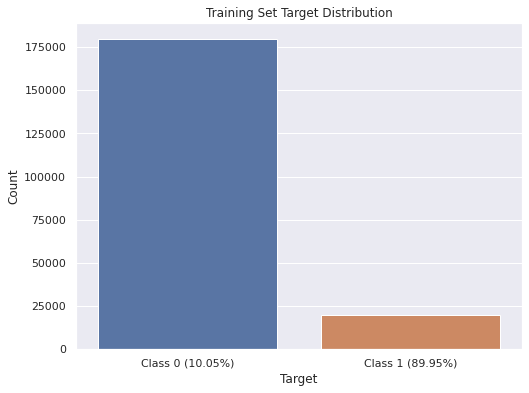

In [13]:
ones = df_train['target'].value_counts()[1]
zeros = df_train['target'].value_counts()[0]
ones_per = ones / df_train.shape[0] * 100
zeros_per = zeros / df_train.shape[0] * 100

print('{} out of {} rows are Class 1 and it is the {:.2f}% of the dataset.'.format(ones, df_train.shape[0], ones_per))
print('{} out of {} rows are Class 0 and it is the {:.2f}% of the dataset.'.format(zeros, df_train.shape[0], zeros_per))

plt.figure(figsize=(8, 6))
sns.countplot(df_train['target'])

plt.xlabel('Target')
plt.xticks((0, 1), ['Class 0 ({0:.2f}%)'.format(ones_per), 'Class 1 ({0:.2f}%)'.format(zeros_per)])
plt.ylabel('Count')
plt.title('Training Set Target Distribution')

plt.show()

### **1.3 Correlations**
Features from `var_0` to `var_199` have extremely low correlation between each other in both training set and test set. The lowest correlation between variables is **2.7e-8** and it is in the training set (between `var_191` and `var_75`). The highest correlation between variables is **0.00986** and it is in the test set (between `var_139` and `var_75`). `target` has slightly higher correlations with other features. The highest correlation between a feature and `target` is **0.08** (between `var_81` and `target`).

In [14]:
df_train_corr = df_train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [15]:
# Top 5 Highest Correlations in the Training Set
df_train_corr_nd.tail()

,Feature 1,Feature 2,Correlation Coefficient
40190,var_110,target,0.064275
40192,var_6,target,0.066731
40194,var_12,target,0.069489
40196,target,var_139,0.074080
40198,target,var_81,0.080917


In [16]:
# Top 5 Highest Correlations between variables in the Training Set
df_train_corr_nd[np.logical_and(df_train_corr_nd['Feature 1'] != 'target', df_train_corr_nd['Feature 2'] != 'target')].tail()

,Feature 1,Feature 2,Correlation Coefficient
39868,var_183,var_189,0.009359
39870,var_81,var_174,0.009490
39872,var_165,var_81,0.009714
39874,var_53,var_148,0.009788
39876,var_139,var_26,0.009844


In [17]:
# Top 5 Highest Correlations in the Test Set
df_test_corr_nd.tail()

,Feature 1,Feature 2,Correlation Coefficient
39790,var_122,var_164,0.008513
39792,var_164,var_2,0.008614
39794,var_31,var_132,0.008714
39796,var_96,var_143,0.008829
39798,var_139,var_75,0.009868


### **1.4 Unique Value Count**
The lowest unique value count belongs to `var_68` which has only **451** unique values in training set and **428** unique values in test set. **451** and **428** unique values in **200000** rows are too less that `var_68` could even be a categorical feature. The highest unique value count belongs to`var_45` which has **169968** unique values in the training set and **92058** unique values in the test set. Every feature in training set have higher unique value counts compared to features in test set.

The lowest unique value count difference is in the `var_68` feature (Training Set Unique Count **451**, Test Set Unique Count **428**). The highest unique value count difference is in the `var_45` feature (Training Set Unique Count **169968**, Test Set Unique Count **92058**). When the unique value count of a feature increases, the difference between training set unique value count and test set unique value count also increases. The explanation of this situation is probably the synthetic records in the test set. 

In [18]:
df_train_unique = df_train.agg(['nunique']).transpose().sort_values(by='nunique')
df_test_unique = df_test.agg(['nunique']).transpose().sort_values(by='nunique')
df_uniques = df_train_unique.drop('target').reset_index().merge(df_test_unique.reset_index(), how='left', right_index=True, left_index=True)
df_uniques.drop(columns=['index_y'], inplace=True)
df_uniques.columns = ['Feature', 'Training Set Unique Count', 'Test Set Unique Count']

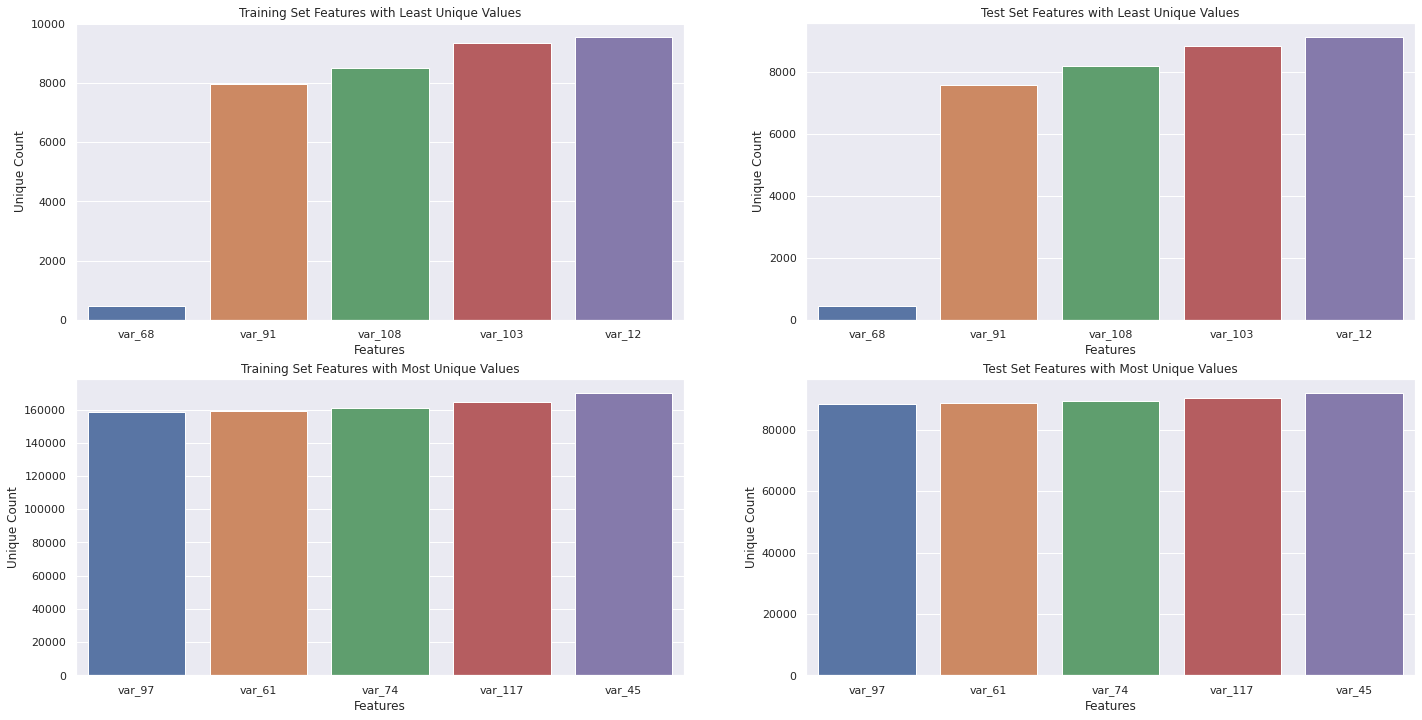

In [19]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(24, 12))

sns.barplot(x=df_train_unique.index[1:6], y="nunique", data=df_train_unique[1:].head(), ax=axs[0][0])
sns.barplot(x=df_test_unique.index[:5], y="nunique", data=df_test_unique.head(), ax=axs[0][1])
sns.barplot(x=df_train_unique.index[-6:-1], y="nunique", data=df_train_unique[-6:-1].tail(), ax=axs[1][0])
sns.barplot(x=df_test_unique.index[-6:-1], y="nunique", data=df_test_unique[-6:-1].tail(), ax=axs[1][1])

for i in range(2):
    for j in range(2):        
        axs[i][j].set(xlabel='Features', ylabel='Unique Count')
        
axs[0][0].set_title('Training Set Features with Least Unique Values')
axs[0][1].set_title('Test Set Features with Least Unique Values')
axs[1][0].set_title('Training Set Features with Most Unique Values')
axs[1][1].set_title('Test Set Features with Most Unique Values')

plt.show()

### **1.6 Feature Distributions in Training and Test Set**
Training and test set distributions of features are not perfectly identical. There are bumps on the distribution peaks of test set because the unique value counts are lesser than training set. Distribution tails are smoother than peaks and spikes are present in both training and test set.

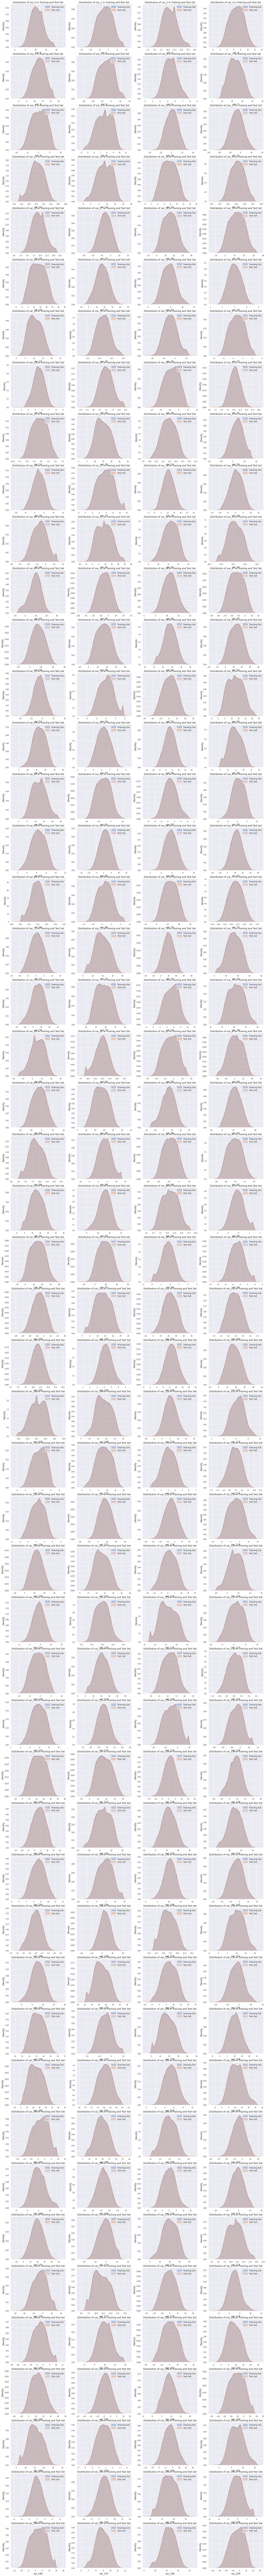

In [20]:
features = [col for col in df_train.columns.tolist() if col.startswith('var')]

nrows = 50
fig, axs = plt.subplots(nrows=50, ncols=4, figsize=(24, nrows * 5))

for i, feature in enumerate(features, 1):
    plt.subplot(50, 4, i)
    sns.kdeplot(df_train[feature], bw='silverman', label='Training Set', shade=True)
    sns.kdeplot(df_test[feature], bw='silverman', label='Test Set', shade=True)
    
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)
    
    plt.legend(loc='upper right')
    plt.title('Distribution of {} in Training and Test Set'.format(feature))
    
plt.show()

### **1.8 Conclusion**
Data imbalance is very common in customer datasets like this. Oversampling **Class 1** or undersampling **Class 0** are suitable solutions for this dataset because of its large size. Since the dataset is big enough, resampling would not introduce underfitting.

Training set has more unique values than test set so some part of test set is most likely synthetic. Rows with more frequent values are less reliable because test set has bumps over distribution peaks. This is also related to synthetic data in test set.

Features are not correlated with each other or not dependent to each other. However, `target` feature has the highest correlation with `var_81` (**0.08**). This relationship can bu used to make other features more informative. If a feature is target encoded on `var_81`, it could give information about `target`.

Values in **1st** and **4th** quartiles have higher chance to be **Class 1** than values in **2nd** and **3rd** quartile for almost every feature because of winsorization.

## **2. Feature Engineering and Data Augmentation**

### **2.1 Separating Real/Synthetic Test Data and Magic Features**
Using unique value count in a row to identify synthetic samples. If a row has at least one unique value in a feature, then it is real, otherwise it is synthetic.This way the unusual bumps on the distribution peaks of test set features are captured. The  features are extracted from the combination of training set and real samples in the test set. 

In [5]:
test = df_test.drop(['ID_code'], axis=1).values

unique_count = np.zeros_like(test)

for feature in range(test.shape[1]):
    _, index, count = np.unique(test[:, feature], return_counts=True, return_index=True)
    unique_count[index[count == 1], feature] += 1
    
real_samples = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synth_samples = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print('Number of real samples in test set is {}'.format(len(real_samples)))
print('Number of synthetic samples in test set is {}'.format(len(synth_samples)))

Number of real samples in test set is 100000
Number of synthetic samples in test set is 100000


In [6]:
features = [col for col in df_train.columns if col.startswith('var')]
df_all = pd.concat([df_train, df_test.iloc[real_samples]])

for feature in features:
    temp = df_all[feature].value_counts(dropna=True)

    df_train[feature + 'vc'] = df_train[feature].map(temp).map(lambda x: min(10, x)).astype(np.uint8)
    df_test[feature + 'vc'] = df_test[feature].map(temp).map(lambda x: min(10, x)).astype(np.uint8)

    df_train[feature + 'sum'] = ((df_train[feature] - df_all[feature].mean()) * df_train[feature + 'vc'] \
                                 .map(lambda x: int(x > 1))).astype(np.float32)
    df_test[feature + 'sum'] = ((df_test[feature] - df_all[feature].mean()) * df_test[feature + 'vc'] \
                                .map(lambda x: int(x > 1))).astype(np.float32) 

    df_train[feature + 'sum2'] = ((df_train[feature]) * df_train[feature + 'vc'] \
                                  .map(lambda x: int(x > 2))).astype(np.float32)
    df_test[feature + 'sum2'] = ((df_test[feature]) * df_test[feature + 'vc'] \
                                 .map(lambda x: int(x > 2))).astype(np.float32)

    df_train[feature + 'sum3'] = ((df_train[feature]) * df_train[feature + 'vc'] \
                                  .map(lambda x: int(x > 4))).astype(np.float32) 
    df_test[feature + 'sum3'] = ((df_test[feature]) * df_test[feature + 'vc'] \
                                 .map(lambda x: int(x > 4))).astype(np.float32)
    
print('Training set shape after creating magic features: {}'.format(df_train.shape))
print('Test set shape after creating magic features: {}'.format(df_test.shape))

Training set shape after creating magic features: (200000, 1002)
Test set shape after creating magic features: (200000, 1001)


### **2.2 Data Augmentation**
Oversampling the data increases CV and LB score significantly since the data is imbalanced.Only 10% of the features are Target = 1, which implies that there is imbalance in the data. To overcome the imbalance in the data, we have two options Undersampling and Oversampling the data. We didn’t want to sacrifice the information in the data, so we chose the oversampling of the data. As target =1 are in less numbers, we are oversampling Target = 1 by 3 times which increases our number of samples to train on by increasing the percentage of samples where Target = 1 and solves the imbalance problem. We also doubled Target = 0 samples so the new sample distribution is similar to the original.


In [7]:
def oversampling(x, y, t=2):
    
    xs, xn = [], []
    
    for i in range(t // 2):
        mask = y == 0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        featnum = x1.shape[1] // 200 - 1

        for c in range(200):
            np.random.shuffle(ids)
            x1[:, [c] + [200 + featnum * c + idc for idc in range(featnum)]] = x1[ids][:, [c] + [200 + featnum * c + idc for idc in range(featnum)]]
        xn.append(x1)
    
    for i in range(t):
        mask = y > 0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        featnum = x1.shape[1] // 200 - 1
        
        for c in range(200):
            np.random.shuffle(ids)
            x1[:, [c] + [200 + featnum * c + idc for idc in range(1)]] = x1[ids][:, [c] + [200 + featnum * c + idc for idc in range(1)]]
        xs.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x, xs, xn])
    y = np.concatenate([y, ys, yn])
    
    return x, y

## **3. Model**

### **LightGBM** Model hyperparameters combination 1


In [22]:
gbdt_param1 = {
    # Core Parameters
    'objective': 'binary',
    'boosting': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 15,
    'tree_learner': 'serial',
    'num_threads': 8,
    'seed': SEED,
    
    # Learning Control Parameters
    'max_depth': -1,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 10,  
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'feature_fraction': 0.05,
    'lambda_l1': 1.,
    'bagging_seed': SEED,
    
    # Others
    'verbosity ': 1,
    'boost_from_average': False,
    'metric': 'auc',
}

In [23]:
predictors = df_train.columns.tolist()[2:]
X_test = df_test[predictors]

n_splits = 5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

predictions = df_test[['ID_code']]

In [24]:
for fold, (train_ind, val_ind) in enumerate(skf.split(df_train, df_train.target.values)):
    
    X_train, y_train = df_train.iloc[train_ind][predictors], df_train.iloc[train_ind]['target']
    X_valid, y_valid = df_train.iloc[val_ind][predictors], df_train.iloc[val_ind]['target']

    N = 1
    p_valid, yp = 0, 0
        
    for i in range(N):
        print('\nFold {} - N {}'.format(fold + 1, i + 1))
        
        X_t, y_t = oversampling(X_train.values, y_train.values)
        weights = np.array([0.8] * X_t.shape[0])
        weights[:X_train.shape[0]] = 1.0
        print('Shape of X_train after augment: {}\nShape of y_train after augment: {}'.format(X_t.shape, y_t.shape))
        
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t, weight=weights)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        
        lgb_clf = lgb.train(gbdt_param1, trn_data, 100000, valid_sets=[trn_data, val_data], early_stopping_rounds=5000, verbose_eval=1000, evals_result=evals_result)
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
        

    predictions['fold{}'.format(fold + 1)] = yp / N



Fold 1 - N 1
Shape of X_train after augment: (336079, 1000)
Shape of y_train after augment: (336079,)
Training until validation scores don't improve for 5000 rounds.
[1000]	training's auc: 0.959938	valid_1's auc: 0.883442
[2000]	training's auc: 0.969074	valid_1's auc: 0.902682
[3000]	training's auc: 0.973999	valid_1's auc: 0.912162
[4000]	training's auc: 0.97716	valid_1's auc: 0.917175
[5000]	training's auc: 0.97942	valid_1's auc: 0.91997
[6000]	training's auc: 0.981273	valid_1's auc: 0.921527
[7000]	training's auc: 0.982897	valid_1's auc: 0.922518
[8000]	training's auc: 0.984431	valid_1's auc: 0.923067
[9000]	training's auc: 0.985854	valid_1's auc: 0.923447
[10000]	training's auc: 0.987192	valid_1's auc: 0.923677
[11000]	training's auc: 0.988439	valid_1's auc: 0.923706
[12000]	training's auc: 0.989605	valid_1's auc: 0.923751
[13000]	training's auc: 0.990674	valid_1's auc: 0.923697
[14000]	training's auc: 0.991668	valid_1's auc: 0.923551
[15000]	training's auc: 0.992586	valid_1's auc:

In [ ]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("lgb_submission_best.csv", index=False)

### **LightGBM** Model paramter combination 2

In [30]:
gbdt_param2 =  {"objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.4,
    "feature_fraction" : 0.05,
    "min_data_in_leaf": 80,
    "min_sum_heassian_in_leaf": 10,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : SEED,
    "verbosity" : 1,
    "seed": SEED}


In [31]:
predictors = df_train.columns.tolist()[2:]
X_test = df_test[predictors]

n_splits = 5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

predictions = df_test[['ID_code']]

In [32]:
for fold, (train_ind, val_ind) in enumerate(skf.split(df_train, df_train.target.values)):
    
    X_train, y_train = df_train.iloc[train_ind][predictors], df_train.iloc[train_ind]['target']
    X_valid, y_valid = df_train.iloc[val_ind][predictors], df_train.iloc[val_ind]['target']

    N = 1
    p_valid, yp = 0, 0
        
    for i in range(N):
        print('\nFold {} - N {}'.format(fold + 1, i + 1))
        
        X_t, y_t = oversampling(X_train.values, y_train.values)
        weights = np.array([0.8] * X_t.shape[0])
        weights[:X_train.shape[0]] = 1.0
        print('Shape of X_train after augment: {}\nShape of y_train after augment: {}'.format(X_t.shape, y_t.shape))
        
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t, weight=weights)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        
        lgb_clf = lgb.train(gbdt_param2, trn_data, 100000, valid_sets=[trn_data, val_data], early_stopping_rounds=5000, verbose_eval=1000, evals_result=evals_result)
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)

  
    
    predictions['fold{}'.format(fold + 1)] = yp / N



Fold 1 - N 1
Shape of X_train after augment: (336079, 1000)
Shape of y_train after augment: (336079,)
Training until validation scores don't improve for 5000 rounds.
[1000]	training's auc: 0.959024	valid_1's auc: 0.882768
[2000]	training's auc: 0.968122	valid_1's auc: 0.902519
[3000]	training's auc: 0.972894	valid_1's auc: 0.912383
[4000]	training's auc: 0.975971	valid_1's auc: 0.917264
[5000]	training's auc: 0.97828	valid_1's auc: 0.919989
[6000]	training's auc: 0.980213	valid_1's auc: 0.921612
[7000]	training's auc: 0.981975	valid_1's auc: 0.922568
[8000]	training's auc: 0.983621	valid_1's auc: 0.923165
[9000]	training's auc: 0.985136	valid_1's auc: 0.923556
[10000]	training's auc: 0.986557	valid_1's auc: 0.923817
[11000]	training's auc: 0.987871	valid_1's auc: 0.923899
[12000]	training's auc: 0.989124	valid_1's auc: 0.923894
[13000]	training's auc: 0.990274	valid_1's auc: 0.923841
[14000]	training's auc: 0.991309	valid_1's auc: 0.923793
[15000]	training's auc: 0.992274	valid_1's au

In [33]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("lgb_submission__comb_2.csv", index=False)


In [34]:
from google.colab import files
files.download('lgb_submission__comb_2.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **LightGBM** Model paramter combination 3

In [8]:
gbdt_param3 =   {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 5,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'learning_rate': 0.05,
    "bagging_seed" : SEED,
    "verbosity" : 1,
    "seed": SEED
}


In [9]:
predictors = df_train.columns.tolist()[2:]
X_test = df_test[predictors]

n_splits = 5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)


predictions = df_test[['ID_code']]

In [10]:
for fold, (train_ind, val_ind) in enumerate(skf.split(df_train, df_train.target.values)):
    
    X_train, y_train = df_train.iloc[train_ind][predictors], df_train.iloc[train_ind]['target']
    X_valid, y_valid = df_train.iloc[val_ind][predictors], df_train.iloc[val_ind]['target']

    N = 1
    p_valid, yp = 0, 0
        
    for i in range(N):
        print('\nFold {} - N {}'.format(fold + 1, i + 1))
        
        X_t, y_t = oversampling(X_train.values, y_train.values)
        weights = np.array([0.8] * X_t.shape[0])
        weights[:X_train.shape[0]] = 1.0
        print('Shape of X_train after augment: {}\nShape of y_train after augment: {}'.format(X_t.shape, y_t.shape))
        
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t, weight=weights)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        
        lgb_clf = lgb.train(gbdt_param3, trn_data, 100000, valid_sets=[trn_data, val_data], early_stopping_rounds=5000, verbose_eval=1000, evals_result=evals_result)
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)

   
    predictions['fold{}'.format(fold + 1)] = yp / N



Fold 1 - N 1
Shape of X_train after augment: (336079, 1000)
Shape of y_train after augment: (336079,)
Training until validation scores don't improve for 5000 rounds.
[1000]	training's auc: 0.970292	valid_1's auc: 0.90842
[2000]	training's auc: 0.977445	valid_1's auc: 0.920531
[3000]	training's auc: 0.982036	valid_1's auc: 0.921971
[4000]	training's auc: 0.985899	valid_1's auc: 0.921979
[5000]	training's auc: 0.98882	valid_1's auc: 0.921592
[6000]	training's auc: 0.991198	valid_1's auc: 0.9211
[7000]	training's auc: 0.993037	valid_1's auc: 0.920202
[8000]	training's auc: 0.994507	valid_1's auc: 0.919582
Early stopping, best iteration is:
[3664]	training's auc: 0.984693	valid_1's auc: 0.922107

Fold 2 - N 1
Shape of X_train after augment: (336079, 1000)
Shape of y_train after augment: (336079,)
Training until validation scores don't improve for 5000 rounds.
[1000]	training's auc: 0.97042	valid_1's auc: 0.909485
[2000]	training's auc: 0.977473	valid_1's auc: 0.920496
[3000]	training's au

In [11]:
predictions['target'] = np.mean(predictions[[col for col in predictions.columns if col not in ['ID_code', 'target']]].values, axis=1)
predictions.to_csv('predictions.csv', index=None)
sub_df = pd.DataFrame({"ID_code":df_test["ID_code"].values})
sub_df["target"] = predictions['target']
sub_df.to_csv("lgb_submission__comb_3.csv", index=False)

In [12]:
from google.colab import files
files.download('lgb_submission__comb_3.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
! python --version

Python 3.7.10
